# Exploración TrOCR

## Imports y paths

In [1]:
import json
from pathlib import Path
from textwrap import shorten
import re
import unicodedata
from datetime import datetime
import matplotlib.pyplot as plt

import pandas as pd

ROOT = Path("..").resolve()
OCR_OUTPUT_ROOT = ROOT / "data" / "interim" / "ocr_train"

## Cargar todos los JSON de OCR

In [2]:
def loadOcrJsons(base_dir: Path):
    rows = []

    if not base_dir.exists():
        raise FileNotFoundError(f"no existe {base_dir}, corre primero trocr_infer.py")

    for cat_dir in sorted(base_dir.iterdir()):
        if not cat_dir.is_dir():
            continue

        category = cat_dir.name
        json_paths = sorted(cat_dir.glob("*.json"))

        for jpath in json_paths:
            with jpath.open("r", encoding="utf-8") as f:
                data = json.load(f)

            full_text = data.get("full_text", "") or ""
            num_pages = data.get("num_pages", 0)

            header_text = data.get("header_text", "") or ""
            items_text  = data.get("items_text", "") or ""
            totals_text = data.get("totals_text", "") or ""  # por si luego lo agregas

            rows.append({
                "category": category,
                "json_path": str(jpath),
                "pdf_path": data.get("pdf_path", ""),
                "model_name": data.get("model_name", ""),
                "num_pages": num_pages,
                "full_text": full_text,
                "header_text": header_text,
                "items_text": items_text,
                "totals_text": totals_text,
                "num_chars": len(full_text),
                "num_lines": full_text.count("\n") + 1 if full_text else 0,
            })

    df = pd.DataFrame(rows)
    return df


df_ocr = loadOcrJsons(OCR_OUTPUT_ROOT)
df_ocr.head()

,category,json_path,pdf_path,model_name,num_pages,full_text,header_text,items_text,totals_text,num_chars,num_lines
0,alimentacion_restaurantes,D:\repositorios\UVG\2025\BudgetBuddy\data\inte...,data/splits/train/alimentacion_restaurantes/0A...,models/trocr_fel_v1,1,"EMOR FHA F |EGOSATAL,IED ANIM\nEC:230303031203...","EMOR FHA F |EGOSATAL,IED ANIM\nEC:230303031203...","EMOR FHA F |EGOSATAL,IED ANIM\nEC:230303030803...",,153,8
1,alimentacion_restaurantes,D:\repositorios\UVG\2025\BudgetBuddy\data\inte...,data/splits/train/alimentacion_restaurantes/0D...,models/trocr_fel_v1,1,"EMOR SUR ELLE SOCADONA SOCAD,IED ANIM\nEC:---2...","EMOR SUR ELLE SOCADONA SOCAD,IED ANIM\nEC:---2...",EMOR SUR ELLE SOCADONA SOCAD?ONA?ONAC?ON A\nEC...,,185,10
2,alimentacion_restaurantes,D:\repositorios\UVG\2025\BudgetBuddy\data\inte...,data/splits/train/alimentacion_restaurantes/1B...,models/trocr_fel_v1,1,"EMOR SUR ELLE SOCADONA SOCAD,IED ANIM\nEC:---E...","EMOR SUR ELLE SOCADONA SOCAD,IED ANIM\nEC:---E...","EMOR FHA F |EGOSATAL,IED ANIM\nEC:230303030803...",,164,8
3,alimentacion_restaurantes,D:\repositorios\UVG\2025\BudgetBuddy\data\inte...,data/splits/train/alimentacion_restaurantes/22...,models/trocr_fel_v1,1,EMOR SUR ELLEUN SOCADONA SOCAD?ONA?ONAC?ONASON...,EMOR SUR ELLEUN SOCADONA SOCAD?ONA?ONAC?ONASON...,"EMOR FHA F |EGOSATAL,IED ANIM\nEC:230803030308...",,214,6
4,alimentacion_restaurantes,D:\repositorios\UVG\2025\BudgetBuddy\data\inte...,data/splits/train/alimentacion_restaurantes/32...,models/trocr_fel_v1,1,"EMOR SUR ELLE SOCADONA SOCAD,IED ANIM\nEC:---E...","EMOR SUR ELLE SOCADONA SOCAD,IED ANIM\nEC:---E...",EMOR SUR ELLE SOCADONA SOCAD?ONA?ONAC?ON A\nEC...,,188,10


## Resumen general

In [3]:
def describeGlobalStats(df: pd.DataFrame):
    print("total facturas:", len(df))
    print("categorias:", sorted(df["category"].unique().tolist()))
    print()

    print("resumen de longitud de texto (num_chars):")
    display(df["num_chars"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

    print("\nresumen de lineas (num_lines):")
    display(df["num_lines"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))


describeGlobalStats(df_ocr)

total facturas: 608
categorias: ['alimentacion_restaurantes', 'compras_electronicos', 'compras_personales', 'finanzas', 'hogar', 'mascotas_veterinaria', 'salud', 'servicios_internet_telefonia', 'servicios_seguros', 'supermercados', 'transporte']

resumen de longitud de texto (num_chars):


count    608.000000
mean     171.544408
std       19.219482
min      119.000000
10%      147.000000
25%      159.000000
50%      173.000000
75%      184.000000
90%      194.000000
max      337.000000
Name: num_chars, dtype: float64


resumen de lineas (num_lines):


count    608.000000
mean       8.136513
std        1.424468
min        5.000000
10%        6.000000
25%        7.000000
50%        8.000000
75%        9.000000
90%       10.000000
max       13.000000
Name: num_lines, dtype: float64

## Stats por categoría

In [4]:
def describeByCategory(df: pd.DataFrame):
    grouped = (
        df.groupby("category")["num_chars"]
        .agg(["count", "mean", "median", "min", "max"])
        .reset_index()
        .sort_values("count", ascending=False)
    )
    grouped["mean"] = grouped["mean"].round(2)
    grouped["median"] = grouped["median"].round(2)
    display(grouped)


describeByCategory(df_ocr)

,category,count,mean,median,min,max
8,servicios_seguros,172,165.26,172.0,147,198
1,compras_electronicos,78,171.69,172.0,119,229
7,servicios_internet_telefonia,66,167.42,177.0,136,194
6,salud,61,174.70,176.0,135,249
2,compras_personales,43,180.74,177.0,140,337
10,transporte,40,185.35,188.5,141,213
9,supermercados,39,173.97,168.0,139,222
0,alimentacion_restaurantes,34,168.82,166.5,144,214
3,finanzas,34,180.32,183.0,142,230
4,hogar,24,169.12,172.0,139,204


## Explorar muestras aleatorias

In [5]:
def showRandomSamples(df: pd.DataFrame, category: str | None = None, n: int = 5):
    sample_df = df
    if category is not None:
        sample_df = df[df["category"] == category]

    if sample_df.empty:
        print("no hay filas para el filtro dado")
        return

    sample_df = sample_df.sample(min(n, len(sample_df)), random_state=42)

    for idx, row in sample_df.iterrows():
        print("=" * 80)
        print(f"categoria     : {row['category']}")
        print(f"pdf_path      : {row['pdf_path']}")
        print(f"json_path     : {row['json_path']}")
        print(f"num_pages     : {row['num_pages']}")
        print(f"num_chars     : {row['num_chars']}")
        print("- full_text (abreviado) -")
        print(shorten(row["full_text"], width=200, placeholder="..."))
        print()
        
showRandomSamples(df_ocr, n=5)        

categoria     : compras_electronicos
pdf_path      : data/splits/train/compras_electronicos/F7F39364-D6DD-452E-9E24-309E3B7DE625.pdf
json_path     : D:\repositorios\UVG\2025\BudgetBuddy\data\interim\ocr_train\compras_electronicos\F7F39364-D6DD-452E-9E24-309E3B7DE625.json
num_pages     : 1
num_chars     : 197
- full_text (abreviado) -
EMOR SUR ELLEUN SOCADONA SOCAD?ONA?ONAC?IM EC:---230303031503031603031415151503T: OTAL 9. ED: EDED:. ES:QA GT EMOR FHA F |EGOSATAL,IED ANIM EC:23030303080303280303T:230803080803280803T 4500MONA GT

categoria     : alimentacion_restaurantes
pdf_path      : data/splits/train/alimentacion_restaurantes/6BEE632F-5C6C-4620-AAAF-1E126373636B.pdf
json_path     : D:\repositorios\UVG\2025\BudgetBuddy\data\interim\ocr_train\alimentacion_restaurantes\6BEE632F-5C6C-4620-AAAF-1E126373636B.json
num_pages     : 1
num_chars     : 146
- full_text (abreviado) -
EMOR FHA F |EGOSATAL,IED ANIM EC:23030303080303280303T:. OTAL 4000MONA GT EMOR FHA F |EGOSATAL,IED ANIM EC:23030303

## Distribución de longitudes

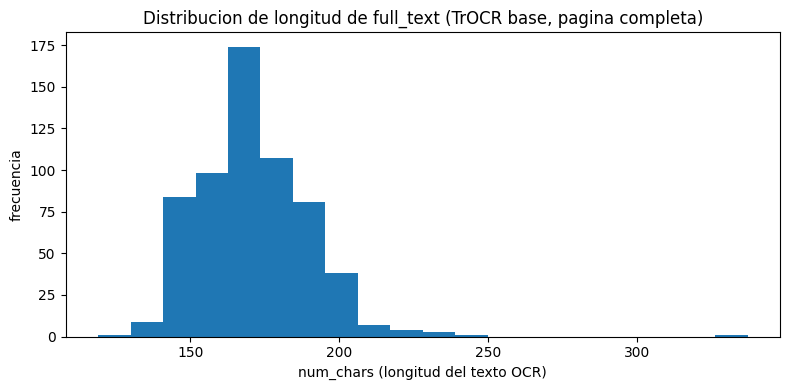

In [6]:
def plotLengthHistogram(df: pd.DataFrame, bins: int = 20):
    plt.figure(figsize=(8, 4))
    plt.hist(df["num_chars"], bins=bins)
    plt.xlabel("num_chars (longitud del texto OCR)")
    plt.ylabel("frecuencia")
    plt.title("Distribucion de longitud de full_text (TrOCR base, pagina completa)")
    plt.tight_layout()
    plt.show()


plotLengthHistogram(df_ocr, bins=20)

## Ground Truth

In [7]:
GT_PATH = ROOT / "data" / "processed" / "ocr_ground_truth_candidates.csv"

gt = pd.read_csv(GT_PATH)
print(gt.shape)
gt.head()

(33, 7)


,pdf_path,category,pdf_filename,emisor,fecha_emision,total,moneda
0,data/splits/train/alimentacion_restaurantes/62...,alimentacion_restaurantes,62BAD652-BE28-4C21-B67F-308BF71DD750.pdf,POLLO CAMPERO SOCIEDAD ANONIMA,2021-06-25,91.00,GTQ
1,data/splits/train/alimentacion_restaurantes/0D...,alimentacion_restaurantes,0DC02C52-A270-4E82-AE5F-308BF7191B12.pdf,POLLO CAMPERO SOCIEDAD ANONIMA,2022-05-14,117.00,GTQ
2,data/splits/train/alimentacion_restaurantes/9A...,alimentacion_restaurantes,9AE71BE2-50DD-4111-B7B5-BA4A316990CE.pdf,"EL CASTOR, S.A.",2025-02-22,199.00,GTQ
3,data/splits/train/compras_electronicos/65BFBAB...,compras_electronicos,65BFBABB-CFBC-443F-9225-13F5F088899D.pdf,"SOLUCIONES TOTALES EN ELECTRONICA, S.A.",2023-06-03,437.62,GTQ
4,data/splits/train/compras_electronicos/579CF15...,compras_electronicos,579CF15C-52AA-404A-809F-1364EFBC7F21.pdf,"INTELAF, SOCIEDAD ANONIMA",2025-02-27,5151.00,GTQ


In [8]:
df_eval = gt.merge(
    df_ocr,
    on="pdf_path",
    how="inner",
    suffixes=("_gt", "_ocr"),
)

print("filas en ground truth:", len(gt))
print("filas unidas con OCR :", len(df_eval))
df_eval[["pdf_path", "category_gt", "category_ocr"]].head()

filas en ground truth: 33
filas unidas con OCR : 33


,pdf_path,category_gt,category_ocr
0,data/splits/train/alimentacion_restaurantes/62...,alimentacion_restaurantes,alimentacion_restaurantes
1,data/splits/train/alimentacion_restaurantes/0D...,alimentacion_restaurantes,alimentacion_restaurantes
2,data/splits/train/alimentacion_restaurantes/9A...,alimentacion_restaurantes,alimentacion_restaurantes
3,data/splits/train/compras_electronicos/65BFBAB...,compras_electronicos,compras_electronicos
4,data/splits/train/compras_electronicos/579CF15...,compras_electronicos,compras_electronicos


## Helpers

In [9]:
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # minúsculas, sin acentos, solo letras/números/espacios
    s = s.lower()
    s = "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def check_emisor(row) -> bool:
    emisor_gt = normalize_text(row["emisor"])
    if not emisor_gt:
        return False

    header_norm = normalize_text(row.get("header_text", ""))
    full_norm   = normalize_text(row.get("full_text", ""))

    # basta con que el emisor aparezca como substring (muy simple por ahora)
    return (emisor_gt[:15] in header_norm) or (emisor_gt[:15] in full_norm)


def build_date_candidates(iso_date: str):
    """
    iso_date: 'YYYY-MM-DD'
    devuelve formatos típicos como DD/MM/YYYY, DD-MM-YYYY, etc.
    """
    try:
        d = datetime.strptime(iso_date, "%Y-%m-%d")
    except Exception:
        return []

    y = d.year
    m = d.month
    day = d.day

    return [
        f"{day:02d}/{m:02d}/{y}",
        f"{day}/{m}/{y}",
        f"{day:02d}-{m:02d}-{y}",
        f"{day}-{m}-{y}",
        f"{y}-{m:02d}-{day:02d}",
    ]


def check_fecha(row) -> bool:
    fecha_gt = str(row["fecha_emision"])
    if not fecha_gt or fecha_gt == "nan":
        return False

    candidates = build_date_candidates(fecha_gt)
    text = row.get("header_text", "") + "\n" + row.get("full_text", "")
    text = text.replace(" ", "")

    return any(c.replace(" ", "") in text for c in candidates)


def build_total_candidates(total_val) -> list[str]:
    """
    total_val: número (float/int)
    genera variantes tipo '91.00', '91,00', 'Q 91.00', '91'
    """
    try:
        total = float(total_val)
    except Exception:
        return []

    base_dot = f"{total:.2f}"      # 91.00
    base_comma = base_dot.replace(".", ",")  # 91,00
    int_part = str(int(round(total)))        # 91

    return [
        base_dot,
        base_comma,
        int_part,
        f"Q{base_dot}",
        f"Q {base_dot}",
        f"Q{base_comma}",
        f"Q {base_comma}",
    ]


def check_total(row) -> bool:
    total_gt = row["total"]
    candidates = build_total_candidates(total_gt)
    if not candidates:
        return False

    text = row.get("totals_text", "") + "\n" + row.get("items_text", "") + "\n" + row.get("full_text", "")
    text = text.replace(" ", "").replace("\n", "")

    return any(c.replace(" ", "").replace("\n", "") in text for c in candidates)

## Checks y métricas

In [10]:
df_eval["emisor_ok"] = df_eval.apply(check_emisor, axis=1)
df_eval["fecha_ok"]  = df_eval.apply(check_fecha, axis=1)
df_eval["total_ok"]  = df_eval.apply(check_total, axis=1)

df_eval[["pdf_path", "emisor", "emisor_ok", "fecha_emision", "fecha_ok", "total", "total_ok"]].head()

,pdf_path,emisor,emisor_ok,fecha_emision,fecha_ok,total,total_ok
0,data/splits/train/alimentacion_restaurantes/62...,POLLO CAMPERO SOCIEDAD ANONIMA,False,2021-06-25,False,91.00,False
1,data/splits/train/alimentacion_restaurantes/0D...,POLLO CAMPERO SOCIEDAD ANONIMA,False,2022-05-14,False,117.00,False
2,data/splits/train/alimentacion_restaurantes/9A...,"EL CASTOR, S.A.",False,2025-02-22,False,199.00,False
3,data/splits/train/compras_electronicos/65BFBAB...,"SOLUCIONES TOTALES EN ELECTRONICA, S.A.",False,2023-06-03,False,437.62,False
4,data/splits/train/compras_electronicos/579CF15...,"INTELAF, SOCIEDAD ANONIMA",False,2025-02-27,False,5151.00,False


In [11]:
metrics = {
    "n_muestras": len(df_eval),
    "emisor_acc": df_eval["emisor_ok"].mean(),
    "fecha_acc": df_eval["fecha_ok"].mean(),
    "total_acc": df_eval["total_ok"].mean(),
}
metrics

{'n_muestras': 33,
 'emisor_acc': np.float64(0.0),
 'fecha_acc': np.float64(0.0),
 'total_acc': np.float64(0.09090909090909091)}

In [13]:
df_eval.groupby("category_gt")[["emisor_ok", "fecha_ok", "total_ok"]].mean().round(2)

,emisor_ok,fecha_ok,total_ok
category_gt,,,
alimentacion_restaurantes,0.0,0.0,0.00
compras_electronicos,0.0,0.0,0.00
compras_personales,0.0,0.0,0.00
finanzas,0.0,0.0,0.00
hogar,0.0,0.0,0.00
mascotas_veterinaria,0.0,0.0,0.00
salud,0.0,0.0,0.00
servicios_internet_telefonia,0.0,0.0,0.33
servicios_seguros,0.0,0.0,0.33
